In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
from pandas import DataFrame
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')#Guardar el dataset en un drive

Mounted at /content/gdrive


# Obtenemos el dataset

In [ ]:
def generateTrainingExamples(df, time_steps=10, time_after=10):
    X, y = [], []

    for idx in df.trip_id.unique():
        trip_df = df[df.trip_id == idx]
        trip_df.index = range(len(trip_df))

        for i in range(len(trip_df) - time_steps - time_after + 1):
            X.append(trip_df.loc[i:i+time_steps-1, ['x', 'y', 'speed', 'angle(rad)']].values)
            y.append(trip_df.loc[i+time_steps + time_after-1, ['x', 'y']].values)
    
    return np.array(X), np.array(y)

In [ ]:
raw_dataset = pd.read_csv('/content/gdrive/MyDrive/Tarea2/tarea2ML_data.csv',header=0)#, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

In [ ]:
print(raw_dataset.loc[19:100])

     Unnamed: 0              x             y     speed  angle(rad)  trip_id
19           19  610044.713891  5.374952e+06  1.669958    6.261849        0
20           20  610146.977035  5.374953e+06  1.650271    6.264850        0
21           21  610249.621549  5.374952e+06  1.629110    6.268339        0
22           22  610347.643053  5.374951e+06  1.610217    6.273378        0
23           23  610444.896082  5.374952e+06  1.594987    6.279678        0
..          ...            ...           ...       ...         ...      ...
96           96  617564.798637  5.374356e+06  1.717916    6.150927        0
97           97  617666.230354  5.374343e+06  1.688797    6.153748        0
98           98  617767.481320  5.374327e+06  1.657168    6.155387        0
99           99  617867.960730  5.374310e+06  1.626771    6.155321        0
100         100  617959.526831  5.374301e+06  1.600925    6.153182        0

[82 rows x 6 columns]


# Aplicamos MinMax Scaler al dataset

In [ ]:
data = raw_dataset.values[:, 1:-1]
trans = MinMaxScaler()
data = trans.fit_transform(data)
dataset = DataFrame(data)
raw_dataset[list(raw_dataset.columns[1:-1])] = dataset

In [ ]:
# Creamos una función para volver el Y desde los valores entre 0 y 1, a sus coordenadas originales.
def obtener_coordenadas_originales(scaler_inicial, Y):
  scale_inverse = MinMaxScaler()
  scale_inverse.min_, scale_inverse.scale_ = scaler_inicial.min_[0:2], scaler_inicial.scale_[0:2]
  Y_coords = scale_inverse.inverse_transform(Y) 
  return Y_coords

In [ ]:
print(raw_dataset.loc[0:100])

     Unnamed: 0         x         y     speed  angle(rad)  trip_id
0             0  0.042066  0.928932  0.880895    0.961974        0
1             1  0.046257  0.926471  0.881960    0.963640        0
2             2  0.050581  0.924797  0.882806    0.965815        0
3             3  0.054871  0.922934  0.886042    0.968300        0
4             4  0.059292  0.921254  0.888469    0.970792        0
..          ...       ...       ...       ...         ...      ...
96           96  0.410146  0.859590  0.805714    0.978952        0
97           97  0.414047  0.858551  0.792057    0.979401        0
98           98  0.417942  0.857202  0.777223    0.979661        0
99           99  0.421807  0.855734  0.762966    0.979651        0
100         100  0.425329  0.854985  0.750844    0.979310        0

[101 rows x 6 columns]


# Generamos el dataset

In [ ]:
X,Y=generateTrainingExamples(raw_dataset)

In [ ]:
print(X[19,:])
print(Y)

[[1.20889472e-01 9.09849966e-01 7.83221131e-01 9.96605463e-01]
 [1.24822973e-01 9.09987652e-01 7.73987928e-01 9.97083045e-01]
 [1.28771143e-01 9.09843191e-01 7.64063310e-01 9.97638279e-01]
 [1.32541491e-01 9.09785074e-01 7.55202301e-01 9.98440371e-01]
 [1.36282280e-01 9.09875253e-01 7.48058942e-01 9.99443000e-01]
 [1.39801948e-01 9.09940340e-01 7.42771737e-01 5.85424967e-04]
 [1.43268124e-01 9.10336534e-01 7.40150606e-01 1.57203886e-03]
 [1.47014833e-01 9.10562415e-01 7.39865566e-01 2.26261624e-03]
 [1.50786442e-01 9.10715168e-01 7.43065841e-01 2.71765665e-03]
 [1.54323597e-01 9.11283476e-01 7.49887390e-01 2.90526275e-03]]
[[0.12088947 0.90984997]
 [0.12482297 0.90998765]
 [0.12877114 0.90984319]
 ...
 [0.92487349 0.00414209]
 [0.9249814  0.00452211]
 [0.92511786 0.00413481]]


# Dividimos en set de entrenamiento y testeo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

# Definimos la función de pérdida personalizada

In [ ]:
def loss_funtion(y_actual,y_pred):
    custom_loss=kb.sqrt(kb.square(y_actual[:,0]-y_pred[:,0])+kb.square(y_actual[:,1]-y_pred[:,1]))
    return custom_loss

# LSTM NN

In [ ]:
lstm_units = 128
callbacks_lstm = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8)] 
l1_regularizer_factor_lstm = 0.01
l2_regularizer_factor_lstm = 0.001

model_lstm = tf.keras.Sequential()

model_lstm.add(layers.InputLayer(input_shape=(10,4), dtype=tf.float64, name='Input_Layer'))
model_lstm.add(layers.Dense(128)) ##Capa de embedding
model_lstm.add(layers.LSTM(lstm_units,                          
                           input_shape=(10,4), 
                           return_sequences=True, 
                           kernel_regularizer=keras.regularizers.L1L2(l1=l1_regularizer_factor_lstm, l2=l2_regularizer_factor_lstm), 
                           name='LSTM_1')) # https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM 
model_lstm.add(layers.LSTM(2, name='LSTM_2')) # https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
model_lstm.compile('adam', loss=loss_funtion)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 128)           640       
_________________________________________________________________
LSTM_1 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
LSTM_2 (LSTM)                (None, 2)                 1048      
Total params: 133,272
Trainable params: 133,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historylstm = model_lstm.fit(X_train, y_train, validation_split=0.2, batch_size=200, epochs=80, shuffle=True, callbacks=callbacks_lstm)

Epoch 1/80
534/534 [==============================] - 43s 74ms/step - loss: 2.3159 - val_loss: 0.1572
Epoch 2/80
534/534 [==============================] - 39s 73ms/step - loss: 0.1287 - val_loss: 0.1124
Epoch 3/80
534/534 [==============================] - 39s 72ms/step - loss: 0.1093 - val_loss: 0.1078
Epoch 4/80
534/534 [==============================] - 39s 72ms/step - loss: 0.1020 - val_loss: 0.0987
Epoch 5/80
534/534 [==============================] - 38s 72ms/step - loss: 0.0954 - val_loss: 0.0895
Epoch 6/80
534/534 [==============================] - 38s 72ms/step - loss: 0.0936 - val_loss: 0.0889
Epoch 7/80
534/534 [==============================] - 39s 73ms/step - loss: 0.0921 - val_loss: 0.0876
Epoch 8/80
534/534 [==============================] - 39s 72ms/step - loss: 0.0914 - val_loss: 0.0937
Epoch 9/80
534/534 [==============================] - 39s 72ms/step - loss: 0.0905 - val_loss: 0.0907
Epoch 10/80
534/534 [==============================] - 38s 72ms/step - loss: 0.089

In [ ]:
# Función para graficar el proceso de entrenamiento
def train_results(train_loss, val_loss, name=None):
  fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = ((7, 7)))

  ax = axs
  ax.set_title('Loss', fontsize = 25)
  ax.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
  ax.plot(train_loss, label = 'loss_train', color = 'black', linestyle = '-')
  ax.plot(val_loss, label = 'loss_val', color = 'orange')
  ax.set_xlabel('Epochs', fontsize = 13)
  ax.legend()
  plt.savefig(name)

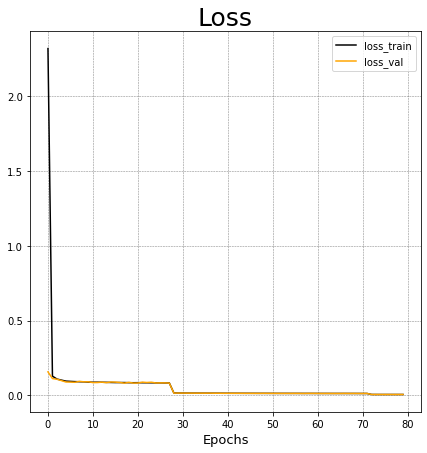

In [ ]:
train_results(train_loss=historylstm.history['loss'],      
              val_loss=historylstm.history['val_loss'],
              name='LSTM.png')

# Convolutional NN

In [ ]:
def get_cnn_model(input_shape):
  '''
  Esta función recibe como input el input_shape de la red y retorna un CNN model compilado.
  '''

  l1_regularizer_factor_cnn = 0.01 
  l2_regularizer_factor_cnn = 0.001


  model_cnn = tf.keras.Sequential()
  model_cnn.add(layers.InputLayer(input_shape=input_shape, 
                                    dtype=tf.float64, 
                                    name='Input_Layer'))  
  model_cnn.add(layers.Conv2D(filters=32, 
                                kernel_size=(4, 4), 
                                padding='same', 
                                activation='relu',                       
                                kernel_regularizer=keras.regularizers.L1L2(l1=l1_regularizer_factor_cnn, 
                                                                          l2=l2_regularizer_factor_cnn) ) )
  model_cnn.add(layers.BatchNormalization())
  model_cnn.add(layers.MaxPool2D(pool_size=(2, 2), 
                                    strides=(2, 2) ) )
  model_cnn.add(layers.Conv2D(filters=32, 
                                kernel_size=(4, 4), 
                                padding='same', 
                                activation='relu',
                                kernel_regularizer=keras.regularizers.L1L2(l1=l1_regularizer_factor_cnn, 
                                                                          l2=l2_regularizer_factor_cnn) ) )
  model_cnn.add(layers.MaxPool2D(pool_size=(2, 2), 
                                    strides=(2, 2) ) )
  model_cnn.add(layers.Flatten())
  model_cnn.add(layers.Dense(units=64, 
                                activation='relu',
                                kernel_regularizer=keras.regularizers.L1L2(l1=l1_regularizer_factor_cnn, 
                                                                          l2=l2_regularizer_factor_cnn) ) )
  model_cnn.add(layers.Dense(units=64, 
                                activation='relu',
                                kernel_regularizer=keras.regularizers.L1L2(l1=l1_regularizer_factor_cnn, 
                                                                          l2=l2_regularizer_factor_cnn) ) )
  model_cnn.add(layers.Dense(units=2, 
                                activation='sigmoid',
                                name='ouput_layer'))

  # Compilamos el modelo
  model_cnn.compile(optimizer='adam',
                    loss=loss_funtion)

  return model_cnn

Probamos primero con el formato orginal (las columnas son las features en la "imagen").

In [ ]:
# Hacemos reshape para ajustar el dataset a formato imagen
X_train_cnn = X_train.reshape(X_train.shape + (1,))
X_test_cnn = X_test.reshape(X_test.shape + (1,))
print('X_train_cnn shape: ',X_train_cnn.shape)
print('X_test_cnn shape: ',X_test_cnn.shape)

# Definimos y entrenamos el modelo
input_shape_cnn = X_train_cnn.shape[1:]
model_cnn = get_cnn_model(input_shape_cnn)

callbacks_cnn = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8)]

history_cnn = model_cnn.fit(X_train_cnn, y_train, validation_split=0.2, batch_size=200, epochs=80, shuffle=True, callbacks=callbacks_cnn)

X_train_cnn shape:  (133335, 10, 4, 1)
X_test_cnn shape:  (33334, 10, 4, 1)
Epoch 1/80
534/534 [==============================] - 13s 23ms/step - loss: 1.8714 - val_loss: 0.3141
Epoch 2/80
534/534 [==============================] - 11s 21ms/step - loss: 0.1872 - val_loss: 0.1823
Epoch 3/80
534/534 [==============================] - 11s 21ms/step - loss: 0.1706 - val_loss: 0.1671
Epoch 4/80
534/534 [==============================] - 11s 21ms/step - loss: 0.1617 - val_loss: 0.1592
Epoch 5/80
534/534 [==============================] - 12s 22ms/step - loss: 0.1543 - val_loss: 0.1514
Epoch 6/80
534/534 [==============================] - 11s 21ms/step - loss: 0.1481 - val_loss: 0.1461
Epoch 7/80
534/534 [==============================] - 11s 21ms/step - loss: 0.1426 - val_loss: 0.1408
Epoch 8/80
534/534 [==============================] - 11s 21ms/step - loss: 0.1385 - val_loss: 0.1372
Epoch 9/80
534/534 [==============================] - 11s 21ms/step - loss: 0.1360 - val_loss: 0.1356
Epoch 

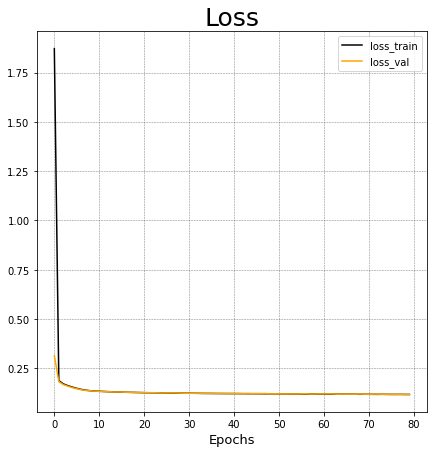

In [ ]:
# Graficamos el proceso de entrenamiento
train_results(train_loss=history_cnn.history['loss'],      
              val_loss=history_cnn.history['val_loss'],
              name='CNN_1.png')

In [ ]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 4, 32)         544       
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 4, 32)         128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 2, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 2, 32)          16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

Ahora probamos transponiendo filas y columnas, en consecuencia, las filas de la "imagen" serán las features.



In [ ]:
# Transponemos filas y columnas en los samples, para el X_train
X_train_transp = X_train.transpose((0,2,1))
X_train_cnn_transp = X_train_transp.reshape(X_train_transp.shape + (1,))
print('X_train_cnn_transp shape: ', X_train_cnn_transp.shape)

# Transponemos filas y columnas en los samples, para el X_test
X_test_transp = X_test.transpose((0,2,1))
X_test_cnn_transp = X_test_transp.reshape(X_test_transp.shape + (1,))
print('X_test_cnn_transp shape: ', X_test_cnn_transp.shape)

# Definimos y entrenamos el modelo
input_shape_cnn_transp = X_train_cnn_transp.shape[1:]
model_cnn_transp = get_cnn_model(input_shape_cnn_transp)

callbacks_cnn_transp = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25),
                        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8)]

history_cnn_transp = model_cnn_transp.fit(X_train_cnn_transp, y_train, validation_split=0.2, batch_size=200, epochs=80, shuffle=True, callbacks=callbacks_cnn_transp)

X_train_cnn_transp shape:  (133335, 4, 10, 1)
X_test_cnn_transp shape:  (33334, 4, 10, 1)
Epoch 1/80
534/534 [==============================] - 13s 22ms/step - loss: 1.8680 - val_loss: 0.3212
Epoch 2/80
534/534 [==============================] - 12s 22ms/step - loss: 0.1767 - val_loss: 0.1670
Epoch 3/80
534/534 [==============================] - 12s 22ms/step - loss: 0.1613 - val_loss: 0.1571
Epoch 4/80
534/534 [==============================] - 12s 22ms/step - loss: 0.1527 - val_loss: 0.1496
Epoch 5/80
534/534 [==============================] - 12s 22ms/step - loss: 0.1455 - val_loss: 0.1456
Epoch 6/80
534/534 [==============================] - 12s 22ms/step - loss: 0.1414 - val_loss: 0.1420
Epoch 7/80
534/534 [==============================] - 12s 22ms/step - loss: 0.1390 - val_loss: 0.1385
Epoch 8/80
534/534 [==============================] - 12s 22ms/step - loss: 0.1373 - val_loss: 0.1366
Epoch 9/80
534/534 [==============================] - 12s 22ms/step - loss: 0.1358 - val_loss:

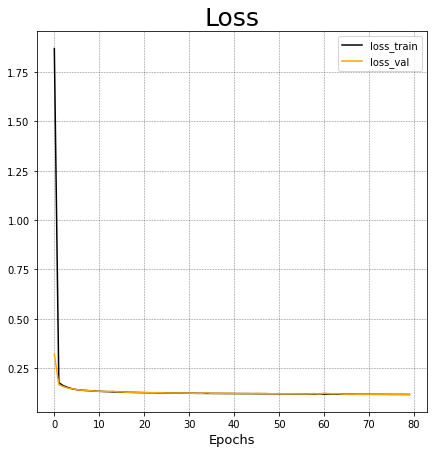

In [ ]:
# Graficamos el proceso de entrenamiento
train_results(train_loss=history_cnn_transp.history['loss'],      
              val_loss=history_cnn_transp.history['val_loss'],
              name='CNN_2.png')

In [ ]:
model_cnn_transp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 4, 10, 32)         544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 10, 32)         128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 5, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 5, 32)          16416     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

# Comparamos los modelos

In [ ]:
# Para hacer las comparaciones, primero se volverá a las coordenadas originales,
# luego se comparán en base al R cuadrado, R cuadrado ajustado y Mean Square Error
y_true = obtener_coordenadas_originales(trans, y_test)

# Usamos el primer modelo CNN para predecir.
y_pred_cnn = model_cnn.predict(X_test_cnn)
# Volvemos a las coordenadas originales el y_pred
y_pred_cnn_coords_originales = obtener_coordenadas_originales(trans, y_pred_cnn) 

# Usamos el segundo modelo CNN para predecir.
y_pred_cnn_transp = model_cnn_transp.predict(X_test_cnn_transp)
# Volvemos a las coordenadas originales el y_pred
y_pred_cnn_transp_coords_originales = obtener_coordenadas_originales(trans, y_pred_cnn_transp)

# Usamos el modelo LSTM para predecir.
y_pred_lstm = model_lstm.predict(X_test)
# Volvemos a las coordenadas originales el y_pred
y_pred_lstm_coords_originales = obtener_coordenadas_originales(trans, y_pred_lstm)

R2 (R cuadrado)

In [ ]:
r2_cnn = r2_score(y_true, y_pred_cnn_coords_originales, 
                  multioutput='variance_weighted')
print('R2 convolutional NN (formato original): ', r2_cnn)

r2_cnn_transp = r2_score(y_true, y_pred_cnn_transp_coords_originales, 
                         multioutput='variance_weighted')
print('R2 convolutional NN (transpuesta): ', r2_cnn_transp)

r2_lstm = r2_score(y_true, y_pred_lstm_coords_originales, 
                         multioutput='variance_weighted')
print('R2 LSTM NN: ', r2_lstm)

R2 convolutional NN (formato original):  0.9432736189821118
R2 convolutional NN (transpuesta):  0.9403072507238409
R2 LSTM NN:  0.9998890479113952


R2 ajustado (R cuadrado ajustado)


In [ ]:
n = X_test.shape[0] # cantidad de samples
p = X_test.shape[2] # cantidad de features

r2_ajustado_cnn = 1- (1-r2_cnn) * (n-1) / (n-p-1)
print('R2 ajustado convolutional NN (formato original): ', r2_ajustado_cnn)

r2_ajustado_cnn_transp = 1- (1-r2_cnn_transp) * (n-1) / (n-p-1)
print('R2 ajustado convolutional NN (transpuesta): ', r2_ajustado_cnn_transp)

r2_ajustado_lstm = 1- (1-r2_lstm) * (n-1) / (n-p-1)
print('R2 ajustado LSTM: ', r2_ajustado_lstm)

R2 ajustado convolutional NN (formato original):  0.9432668109313431
R2 ajustado convolutional NN (transpuesta):  0.9403000866625998
R2 ajustado LSTM:  0.9998890345954135


RMSE (Root Mean Square Error)

In [ ]:
mse_cnn = mean_squared_error(y_true, y_pred_cnn_coords_originales)
mse_cnn_transp = mean_squared_error(y_true, y_pred_cnn_transp_coords_originales)
mse_lstm = mean_squared_error(y_true, y_pred_lstm_coords_originales)

rmse_cnn = np.sqrt(mse_cnn)
print('RMSE convolutional NN (formato original): ', rmse_cnn)

rmse_cnn_transp = np.sqrt(mse_cnn_transp)
print('RMSE convolutional NN (transpuesta): ', rmse_cnn_transp)

rmse_lstm = np.sqrt(mse_lstm)
print('RMSE LSTM: ', rmse_lstm)

RMSE convolutional NN (formato original):  1207.6683750757106
RMSE convolutional NN (transpuesta):  1238.842071400939
RMSE LSTM:  53.41003908990357


# Se intentó implementar la parte opcional...

##Se definió una nueva función de extracción de datos con tal de aumentar el y esperado para poder calcular una media, desviación estándar y correlación

In [ ]:
def generateTrainingExamples2(df, time_steps=10, time_after=10):
    X, y = [], []

    for idx in df.trip_id.unique():
        trip_df = df[df.trip_id == idx]
        trip_df.index = range(len(trip_df))

        for i in range(len(trip_df) - time_steps - time_after + 1):
            X.append(trip_df.loc[i:i+time_steps-1, ['x', 'y', 'speed', 'angle(rad)']].values)
            y.append(trip_df.loc[i+time_steps + time_after-1-5:i+time_steps + time_after-1+5, ['x', 'y']].values)##Se aumento el tamaño de extraccion
    
    return np.array(X), np.array(y)

In [ ]:
X,Y=generateTrainingExamples2(raw_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


##Se obtuvo la media, la desviación estándar y la correlación

In [ ]:
YMEAN=[]
YSTD=[]
YCORR=[]
##Obtenemos la correlacion de x e y
for i in range(166669):
  cosita=np.corrcoef(Y[i].T[0],Y[i].T[1])
  YCORR.append(cosita[0,1])
##Obtenemos la media de x e y
for i in range(166669):
    YMEAN.append(np.mean(Y[i],axis=0))
##Obtenemos la desviacion estadar de x e y
for i in range(166669):
    YSTD.append(np.std(Y[i],axis=0))

YMEAN=np.array(YMEAN)
YSTD=np.array(YSTD)
YCORR=np.array([YCORR])
##Concatenamos y queda (media x, media y, desv x, desv y, corr)
YDEFI=np.concatenate((YMEAN,YSTD,YCORR.T),axis=1)

##Se volvió a dividir el set de entrenamiento y testeo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, YDEFI, test_size=.2)

##Se intentó copiar la funcion de pérdida definida en el paper

In [ ]:
def loss_function_paper(vector_real, vector_predicho):

  # Desglosamos el vector_real
  µ_x = vector_predicho[:,0]
  µ_y = vector_predicho[:,1]
  σ_x = vector_predicho[:,2]
  σ_y = vector_predicho[:,3]
  ρ = vector_predicho[:,4]

  # Desglosamos el vector_predicho
  x = vector_real[:,0]
  y = vector_real[:,1]
  std_x = vector_real[:,2]
  std_y = vector_real[:,3]
  corr = vector_real[:,4]

  # Ecuación 14
  Z = kb.square(x - µ_x)/kb.square(σ_x) + kb.square(y - µ_y)/kb.square(σ_y) - 2*ρ*(x - µ_x)*(y - µ_y)/(σ_x*σ_y)

  # Ecuación 13
  N = kb.exp(-Z/(2*(1-kb.square(ρ)))) / 2*3.14159265*σ_x*σ_y*kb.sqrt(1-kb.square(ρ))

  # Ecuación 12
  Pr = N

  # Ecuación 11
  L = -kb.sum(kb.log(Pr))

  return L

##Luego se definió el modelo del paper

In [ ]:
callbacks_paper = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8)]


inputs = keras.layers.Input(shape=(10, 4), name='Inputs')    # <tf.Tensor 'Inputs:0' shape=(?, 10, 4) dtype=float32>
embedding = keras.layers.Dense(128)(inputs)                       # <tf.Tensor 'dense_1/add:0' shape=(?, 10, 128) dtype=float32>

# Se obtiene la secuencia y el estado h1
lstm_1_sequence, lstm_1_state_h, lstm_1_state_c = keras.layers.LSTM(128, return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.5), name='lstm_1')(embedding)

# Se obtiene la secuencia y el estado h2
lstm_2_sequence, lstm_2_state_h, lstm_2_state_c = keras.layers.LSTM(128, return_sequences=True, return_state=True, kernel_regularizer=regularizers.l2(0.5), name='lstm_2')(lstm_1_sequence)

#Se concatenan los dos estados de las LSTM anteriores
stacked_lstm_output = keras.layers.Concatenate()([lstm_1_state_h, lstm_2_state_h]) # <tf.Tensor 'Reshape:0' shape=(?, 768) dtype=float32>

# Se le entregan los estados a capas densas mlp
output_layer_1 = keras.layers.Dense(128, activation='elu')(stacked_lstm_output)
output_layer_2 = keras.layers.Dense(5, activation=None)(output_layer_1)

#Se compila
model = keras.models.Model(inputs=inputs, outputs=output_layer_2)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              # loss='mse')
              loss=loss_function_paper)##Se le entraga la funcion de perdida del paper
              # loss=tf.keras.losses.BinaryCrossentropy())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             [(None, 10, 4)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 10, 128)      640         Inputs[0][0]                     
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 10, 128), (N 131584      dense[0][0]                      
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 10, 128), (N 131584      lstm_1[0][0]                     
______________________________________________________________________________________________

In [ ]:
historypaper = model.fit(X_train, y_train, validation_split=0.2, batch_size=1000, epochs=80, shuffle=True, callbacks=callbacks_paper)

Epoch 1/80
107/107 [==============================] - 70s 461ms/step - loss: nan - val_loss: nan
Epoch 2/80
107/107 [==============================] - 48s 447ms/step - loss: nan - val_loss: nan
Epoch 3/80
107/107 [==============================] - 48s 448ms/step - loss: nan - val_loss: nan
Epoch 4/80
107/107 [==============================] - 48s 447ms/step - loss: nan - val_loss: nan
Epoch 5/80
107/107 [==============================] - 48s 446ms/step - loss: nan - val_loss: nan
Epoch 6/80
107/107 [==============================] - 48s 446ms/step - loss: nan - val_loss: nan
Epoch 7/80
107/107 [==============================] - 48s 445ms/step - loss: nan - val_loss: nan
Epoch 8/80
107/107 [==============================] - 48s 446ms/step - loss: nan - val_loss: nan
Epoch 9/80
107/107 [==============================] - 48s 446ms/step - loss: nan - val_loss: nan
Epoch 10/80
107/107 [==============================] - 48s 446ms/step - loss: nan - val_loss: nan
Epoch 11/80
107/107 [========

# ... pero no se logró.